In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import sklearn

import librosa 
import librosa.display
import IPython.display as ipd 

from pathlib import Path

In [2]:
# Print genres in the dataset 
music_path = Path("../input/gtzan-dataset-music-genre-classification/Data/genres_original")

genres = [path.name for path in music_path.iterdir()] # .name gets the final path component without the whole path 
print(genres)

general_path = Path("../input/gtzan-dataset-music-genre-classification/Data")


['disco', 'metal', 'reggae', 'blues', 'rock', 'classical', 'jazz', 'hiphop', 'country', 'pop']


The features included in gtzan dataset (All features are included as mean and variance): 

1) Chroma Short-time Fourier Transformation: 



In [ ]:
reg = data.query("filename=='reggae.00036.wav'")

reg[["filename","zero_crossing_rate_mean","zero_crossing_rate_var"]]

## Replicating the notebook results 

The following code runs the algorithms with the 3 seconds feature file. I had to tweak the original file to convert labels into numerical values so that XGBoost will like them. 

SVM did not converge and NN takes a long time to run and in the end did not converge. Both give pretty bad accuracy. 

NN is a multi-layer perceptron classifier. Given a set of features and a target, it approximates the non-linear function. It has two hidden layers - the first layer has 5000 neurons, and the second hidden layer has 10 neurons. This configuration suggests that the NN is supposed to capture very complex patterns in the data.

In [3]:
# Prediction with the 3 second file 

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, f1_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

In [4]:
data = pd.read_csv(f"{general_path}/features_3_sec.csv")

data = data.iloc[0:, 1:] # get rid of the filename column 

In [5]:
# Create feature and target variables 

y = data["label"]
X = data.loc[:, data.columns != "label"]

# Normalize 

cols = X.columns 
min_max_scaler = preprocessing.MinMaxScaler() 
np_scaled = min_max_scaler.fit_transform(X)

X = pd.DataFrame(np_scaled, columns=cols)

In [6]:
# Encode y as numeric (XGBoost does not accept character values)
label_encoder = preprocessing.LabelEncoder() 
y_encoded = label_encoder.fit_transform(y)

In [7]:
# Train - test split 
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.1,
                                                   random_state=42)

In [16]:
# Function to assess accuracy of a model 
def model_assess(model, title="Default"):
    model.fit(X_train,y_train)
    preds = model.predict(X_test) 
    print('Accuracy', title, ":", round(accuracy_score(y_test,preds), 5), "\n")
    print('F-Score', title, ":", round(f1_score(y_test,preds, average="weighted"),5), "\n")

In [18]:
# Models 
# Naive Bayes
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, "Stochastic Gradient Descent")

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "KNN")

# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees")

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")

# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")

# Multinomial Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_assess(lg, "Logistic Regression")

# Neural Nets
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
model_assess(nn, "Neural Nets")

# Cross Gradient Booster
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_assess(xgb, "Cross Gradient Booster")

# Cross Gradient Booster (Random Forest)
xgbrf = XGBRFClassifier(objective= 'multi:softmax')
model_assess(xgbrf, "Cross Gradient Booster (Random Forest)")

Accuracy Naive Bayes : 0.50651 

F-Score Naive Bayes : 0.48095 

Accuracy Stochastic Gradient Descent : 0.64064 

F-Score Stochastic Gradient Descent : 0.63458 

Accuracy KNN : 0.86086 

F-Score KNN : 0.8612 

Accuracy Decission trees : 0.66266 

F-Score Decission trees : 0.66248 

Accuracy Random Forest : 0.83283 

F-Score Random Forest : 0.8304 

Accuracy Support Vector Machine : 0.76777 

F-Score Support Vector Machine : 0.76513 



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy Logistic Regression : 0.71071 

F-Score Logistic Regression : 0.7053 



/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy Neural Nets : 0.65365 

F-Score Neural Nets : 0.64562 

Accuracy Cross Gradient Booster : 0.91692 

F-Score Cross Gradient Booster : 0.91704 

Accuracy Cross Gradient Booster (Random Forest) : 0.76376 

F-Score Cross Gradient Booster (Random Forest) : 0.76152 



In [11]:
y_test

array([4, 5, 0, 0, 6, 9, 7, 2, 2, 0, 8, 2, 5, 4, 2, 8, 5, 1, 3, 3, 5, 2,
       4, 6, 8, 0, 8, 8, 6, 5, 3, 7, 6, 3, 9, 9, 0, 5, 4, 4, 3, 4, 4, 9,
       5, 4, 4, 6, 7, 3, 8, 1, 1, 4, 8, 6, 8, 2, 0, 0, 8, 8, 2, 6, 5, 3,
       8, 1, 9, 3, 4, 6, 2, 9, 2, 2, 3, 7, 8, 1, 1, 7, 4, 4, 4, 4, 8, 2,
       2, 9, 0, 2, 8, 7, 5, 9, 0, 6, 1, 7, 8, 9, 2, 6, 1, 4, 4, 3, 4, 4,
       9, 1, 9, 1, 6, 4, 6, 6, 9, 2, 9, 3, 2, 8, 3, 9, 5, 7, 5, 1, 7, 0,
       4, 1, 9, 0, 0, 1, 0, 3, 1, 7, 7, 5, 9, 1, 4, 9, 7, 4, 5, 1, 0, 8,
       9, 0, 7, 8, 7, 6, 0, 0, 9, 6, 1, 8, 0, 5, 2, 8, 5, 5, 3, 7, 1, 2,
       6, 9, 9, 2, 1, 2, 4, 1, 1, 5, 1, 5, 4, 8, 8, 4, 4, 2, 7, 0, 0, 1,
       7, 8, 8, 5, 4, 8, 8, 1, 9, 9, 8, 3, 3, 0, 7, 0, 7, 1, 7, 9, 9, 4,
       1, 5, 3, 7, 4, 2, 6, 8, 0, 4, 8, 6, 2, 5, 2, 0, 7, 7, 0, 4, 8, 6,
       6, 2, 0, 5, 5, 0, 1, 0, 5, 3, 5, 3, 1, 0, 9, 9, 4, 6, 1, 4, 8, 9,
       1, 6, 1, 0, 7, 2, 0, 5, 9, 5, 5, 6, 8, 4, 0, 2, 8, 8, 1, 9, 5, 4,
       2, 2, 2, 6, 7, 3, 8, 6, 4, 1, 5, 7, 1, 9, 0,

In [12]:
params = {
    'tree_method': ['gpu_hist'],  # Specifies the use of GPU
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    # Add other parameters here
}

xgb = XGBClassifier()
grid_search = GridSearchCV(estimator=xgb, param_grid=params, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

# Grid Search Cross Gradient Booster
from sklearn.model_selection import GridSearchCV 
# Set up parameter grid 

param_grid = {
    'tree_method': ["gpu_hist"],
    "n_estimators": [100,500,1000],
    "learning_rate": [0.01, 0.05, 0.1],
    #"max_depth": [3,6,9],
    #"min_child_weight": [1,3,5]
}

xgb = XGBClassifier()
grid_search = GridSearchCV(estimator=xgb,
                           param_grid=param_grid,
                           scoring="accuracy",
                           cv=3,
                           early_stopping=10,
                           n_jobs=-1)

grid_search.fit(X_train,y_train)
print("Best Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


KeyboardInterrupt: 

## Machine Learning with 30-second Features

In [19]:
# Load the features csv file - 1000 rows + 60 features 
data_30sec = pd.read_csv(f"{general_path}/features_30_sec.csv")
data_30sec.columns

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

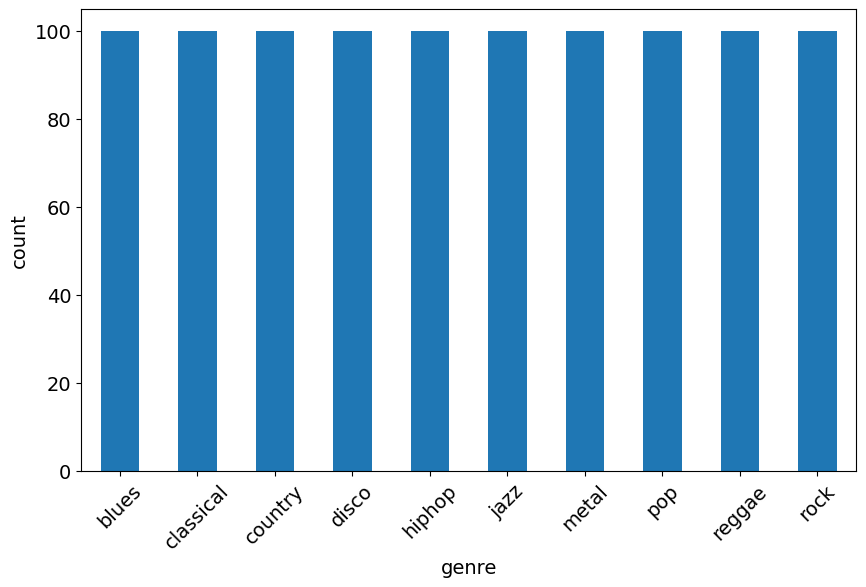

In [35]:
# Graph of genre counts 
label_counts = data_30sec['label'].value_counts()

plt.figure(figsize=(10,6))

label_counts.plot(kind="bar",
               x="label_counts.index",
                 y="label_counts.values")
plt.xlabel("genre", fontsize=14)
plt.ylabel("count", fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('genre_counts.png', dpi=100, bbox_inches='tight')

plt.show()